# Part 1: Control and training data collection via nominal-MPC model

Here, we perform simulated trajectory tracking of a quadrotor under the effects of aerodynamic drag. The quadrotor achieves control by pairing some nominal model of quadrotor dynamcis (burrowed from: ...) with model predictive control. We also collect training and trajectory data for this. We demonstrate in part 2 a control scheme where a Koopman deriveed model of our nosie dynamics (from training data collected here) outperforms this nominal-MPC model for control.

# Configure simulation settings

In [1]:
import numpy as np

# toggle simulation disturbances

simulation_disturbances = {
    "drag": True,
}
    
# define quadrotor and world properties

m = 1.0 # quadrotor mass in [kg]
J = np.array([.03, .03, .06]) # quadrotor moment of inertia vector in [kg⋅m⋅m]
l = 0.235 # length between motor and quadrotor CoG in [m]
c = 0.013 # torque generated by each motor in direction of quadrotor z-axis in [N⋅m]
T_max = 10 # max thrust generated by each motor in [N]
g = 9.81 # gravitational acceleration of world in [m/s/s]
init_pos = np.array([0.0, 1.0, 1.0]) # initial position of quadrotor

# define drag coefficients

rotor_drag = np.array([0.3, 0.3, 0.0])[:, np.newaxis] # rotor drag coefficients in [kg/m]
aero_drag = 0.08 # aerodynamic drag coefficient in [kg/m]

# define MPC and RK4 settings

t_horizon = 1.0 # prediction horizon in [s]
n_mpc_nodes = 10 # number of control nodes within horizon
Q = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]) # weighing matrix for quadratic cost function
R = np.array([0.1, 0.1, 0.1, 0.1]) # weighing matrix for quadratic cost function
simulation_dt = 5e-4 # integration step size in [s]

# define trajectory settings

traj_radius = 5 # radius of trajectory in [m]
traj_v_max = 10 # maximum speed at peak velocity in [m/s]
traj_a_lin = 1 # linear acceleration of trajectory in [m/s/s]
reference_over_sampling = 5

# toggle plotting features

animate_plots = False

# Generate reference trajectory

Please export ACADOS_SOURCE_DIR to avoid this warning.
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR to avoid this warning.
Please export ACADOS_SOURCE_DIR t

ld: warning: directory not found for option '-L-l'


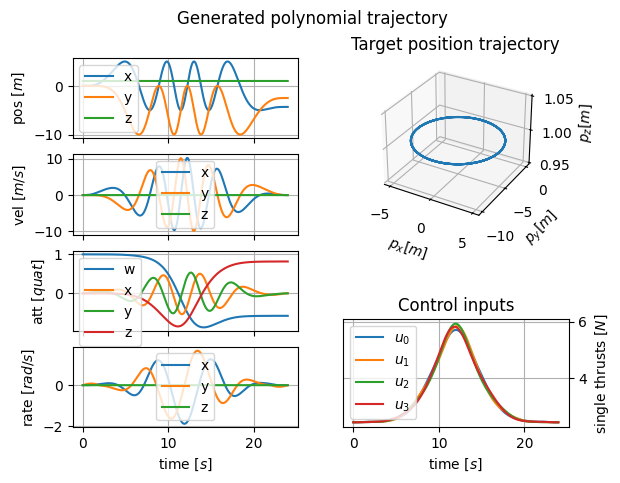

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `[Reference Trajectory](data_dir + 'reference_trajectory.png')'


In [2]:
import os
import sys

import matplotlib.pyplot as plt

from quad import Quad
from quad_mpc_nominal import QuadMPCNominal
from trajectories import check_trajectory, loop_trajectory

# instantiate Quad and QuadMPC objects

quad = Quad(m=m, J=J, l=l, c=c, T_max=T_max, g=g, rotor_drag=rotor_drag, aero_drag=aero_drag, drag=simulation_disturbances["drag"])
quad_mpc = QuadMPCNominal(quad=quad, t_horizon=t_horizon, n_nodes=n_mpc_nodes, Q=Q, R=R)

# generate reference trajectory and control policy (burrowed entirely from https://github.com/uzh-rpg/data_driven_mpc/tree/main)

control_period = t_horizon / (n_mpc_nodes * reference_over_sampling) # sampling period of trajectory

reference_traj, reference_timestamps, reference_u = loop_trajectory(
    quad=quad, discretization_dt=control_period, radius=traj_radius, 
    lin_acc=traj_a_lin, clockwise=True, yawing=False, v_max=traj_v_max, plot=True)

if not check_trajectory(reference_traj, reference_timestamps, plot=False):
    print("Reference trajectory integrity check failed!")
    sys.exit(1)

# compute reference speed

reference_speed = np.linalg.norm(reference_traj[:,7:10], axis=1)

# pin plot of reference trajectory

![Reference Trajectory](data_dir + 'reference_trajectory.png')

# Perform Simulation

In [ ]:
from utils.math import separate_variables
from utils.mpc import get_reference_chunk

# initialize quadrotor state

initial_state = np.split(reference_traj[0, :], [3, 7, 10])
initial_state[0] = init_pos
quad.set_state(*initial_state)

n_quad_states = len(quad.get_state())
n_control_states = len(quad.u)

# begin simulation

quad_traj = np.zeros([len(reference_timestamps), n_quad_states]) # store quadrotor trajectory
opt_u = reference_u[0, :] # optimal control action to be applied in MPC loop
opt_u_history = np.zeros([len(reference_timestamps), n_control_states]) # store optimal control action history
tracking_error = np.zeros(len(reference_timestamps)) # store tracking error

print("\nRunning MPC loop ...")

for i in range(len(reference_timestamps)):
    
    # retrieve and save quadrotor state

    quad_current_state = quad.get_state()
    quad_traj[i, :] = np.expand_dims(quad_current_state, axis=0)

    # compute tracking error

    tracking_error[i] = np.linalg.norm(reference_traj[i, :3] - quad_traj[i, :3])

    # get the chunk of trajectory required for the current optimization (burrowed entirely from https://github.com/uzh-rpg/data_driven_mpc/tree/main)

    ref_traj_chunk, ref_u_chunk = get_reference_chunk(reference_traj, reference_u, i, n_mpc_nodes, reference_over_sampling)

    # set the reference for the OCP
    
    quad_mpc.set_reference(x_ref=separate_variables(ref_traj_chunk), u_ref=ref_u_chunk)

    # solve OCP to retrieve optimized control and state sequences
    
    u_opt_acados, x_opt_acados = quad_mpc.optimize()

    # select first set of control actions as the control to apply to the plant

    opt_u = u_opt_acados[:4]
    opt_u_history[i, :] = np.reshape(opt_u, (1, -1))
    
    # apply control action to quadrotor and update state

    simulation_time = 0.0
    while simulation_time < control_period:
        quad.update(opt_u, simulation_dt)
        simulation_time += simulation_dt

quad_current_state = quad.get_state()
quad_traj[-1, :] = np.expand_dims(quad_current_state, axis=0)

# compute tracking RMSE

tracking_rmse = np.mean(np.sqrt(np.sum((reference_traj[:, :3] - quad_traj[:, :3]) ** 2, axis=1)))

# Print and plot results

In [ ]:
import matplotlib.pyplot as plt

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

print("\n::::::::::::: SIMULATION RESULTS :::::::::::::\n")
print("Final tracking RMSE: %.4f m\n" % tracking_rmse)

fig, axs = plt.subplots(3, 1, figsize=(8, 18))

axs[0].set_xlim(-7, 7); axs[0].set_ylim(-12, 2)
axs[0].set_xlabel('X [m]'); axs[0].set_ylabel('Y [m]')
axs[0].grid(True)
line_traj, = axs[0].plot([], [], color='blue', label='Actual Trajectory')
circle = plt.Circle((0, -traj_radius), radius=traj_radius, color='gray', fill=False, linestyle='dashed', linewidth=2, label='Reference Trajectory')
axs[0].add_patch(circle)

axs[1].set_xlim(0, len(reference_timestamps)); axs[1].set_ylim(0, max(reference_speed))
axs[1].set_xlabel('Step'); axs[1].set_ylabel('Speed [m/s]')
axs[1].grid(True)
line_speed, = axs[1].plot([], [], color='green', label='Reference Speed')

axs[2].set_xlim(0, len(reference_timestamps)); axs[2].set_ylim(0, max(tracking_error))
axs[2].set_xlabel('Step'); axs[2].set_ylabel('Distance [m]')
axs[2].grid(True)
line_error, = axs[2].plot([], [], color='red', label='Tracking Error')

def init():
    line_traj.set_data([], []); line_speed.set_data([], []); line_error.set_data([], [])
    return line_traj, line_speed, line_error, circle

def animate(t):
    x_traj = quad_traj[:t, 0]; y_traj = quad_traj[:t, 1]
    line_traj.set_data(x_traj, y_traj)

    time = np.arange(t); speed = reference_speed[:t]
    line_speed.set_data(time, speed)
        
    error = tracking_error[:t]
    line_error.set_data(time, error)
        
    return line_traj, line_speed, line_error, circle

if animate_plots:
    plt.rcParams['animation.embed_limit'] = 150.0
    animation = FuncAnimation(fig, animate, frames=len(reference_timestamps), init_func=init, interval=1, blit=True)
else:
    line_traj, = axs[0].plot(quad_traj[:,0], quad_traj[:,1], color='blue')
    line_speed, = axs[1].plot(np.arange(len(reference_timestamps)), reference_speed, color='green')
    line_error, = axs[2].plot(np.arange(len(reference_timestamps)), tracking_error, color='red')

axs[0].legend()
axs[1].legend()
axs[2].legend()

if animate_plots:
    animation.save('animation_drag.gif', writer='pillow', fps=30)
    HTML(animation.to_jshtml())